In [1]:
#Imports
import pickle
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2


# Load data functions
# Functions from Cifar page
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def loadLabels(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        return [x.decode('ascii') for x in data[b'label_names']]
    
def intToLabel(a):
    strs = ["" for x in range(len(a))]
    for i in range(len(a)):
        strs[i] = labels[a[i]]
    return strs
    
def batchToObject(batch):
    
    convertToText = np.transpose(np.array(batch[b'labels']))
    for i in range(len(batch[b'labels'])):
        zeroVector = np.zeros((10,1))
        zeroVector[batch[b'labels'][i]] = 1
        batch[b'labels'][i] = np.transpose(zeroVector)[0].astype(int)
    # Create new dictionaries
    batchAsObject =  {
        'images': np.divide(batch[b'data'], 255),
        'label':  np.array(batch[b'labels']),
        'labelText': intToLabel(convertToText)
    }
    return batchAsObject

In [2]:
# Destination to dataset
dataDir = "C:/Users/ottarg/Desktop/KTH_PROGRAM/4-Deep Learning/Assignments/DataSets"

# Load labels
labelDir = dataDir + "/batches.meta"
labels = loadLabels(labelDir)

# Advanced parameters for optimization
TRAIN_ALL_DATA = True

if(TRAIN_ALL_DATA):
    training1 = batchToObject(unpickle(dataDir + "/data_batch_1"))
    training2 = batchToObject(unpickle(dataDir + "/data_batch_2"))
    training3 = batchToObject(unpickle(dataDir + "/data_batch_3"))
    training4 = batchToObject(unpickle(dataDir + "/data_batch_4"))
    training5 = batchToObject(unpickle(dataDir + "/data_batch_5"))
    
    # lenOfBatch
    lb = 10000
    #restForVali
    rV = 200
    #sliceIndex
    sl = lb- rV
    training = {
        'images': np.vstack((training1['images'][0:sl], training2['images'][0:sl], training3['images'][0:sl], training4['images'][0:sl], training5['images'][0:sl])) ,
        'label': np.vstack((training1['label'][0:sl], training2['label'][0:sl], training3['label'][0:sl], training4['label'][0:sl], training5['label'][0:sl])) ,
        'labelText': np.vstack((training1['labelText'][0:sl], training2['labelText'][0:sl], training3['labelText'][0:sl], training4['labelText'][0:sl], training5['labelText'][0:sl])) ,
    }
    validate = {
        'images': np.vstack((training1['images'][sl:lb], training2['images'][sl:lb], training3['images'][sl:lb], training4['images'][sl:lb], training5['images'][sl:lb])) ,
        'label': np.vstack((training1['label'][sl:lb], training2['label'][sl:lb], training3['label'][sl:lb], training4['label'][sl:lb], training5['label'][sl:lb])) ,
        'labelText': np.vstack((training1['labelText'][sl:lb], training2['labelText'][sl:lb], training3['labelText'][sl:lb], training4['labelText'][sl:lb], training5['labelText'][sl:lb])) ,
    }
    
    
else:    
    training = batchToObject(unpickle(dataDir + "/data_batch_1"))
    validate = batchToObject(unpickle(dataDir + "/data_batch_2"))

testing = batchToObject(unpickle(dataDir + "/test_batch"))

train_meanVal = np.mean(np.transpose(training['images']), axis=1)

def calculateBatchNormalize(inputData,meanv):

    nData = np.shape(inputData)[0]
    ones = np.eye(nData,nData)
    
    fir = np.transpose(np.transpose(inputData) - meanv)
    return np.transpose(np.dot(ones, fir))

# You should only compute the mean for the training data and then
# keep a record of this mean and subtract it from the input vectors in the validation and test sets.
training['images'] = calculateBatchNormalize(np.transpose(training['images']), train_meanVal)
validate['images'] = calculateBatchNormalize(np.transpose(validate['images']), train_meanVal)
testing['images']  = calculateBatchNormalize(np.transpose(testing['images']) , train_meanVal)



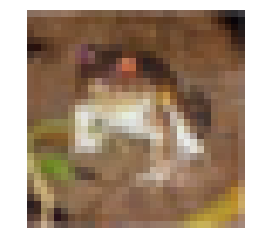

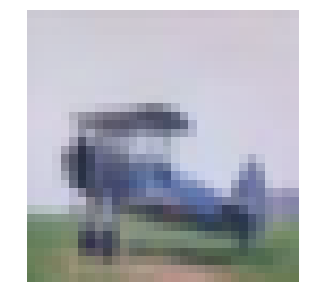

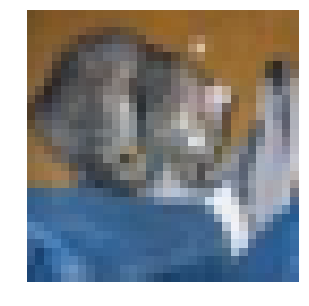

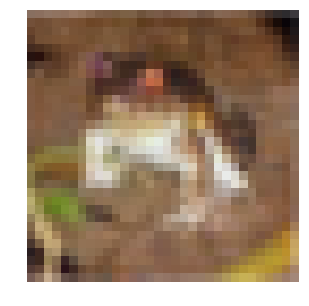

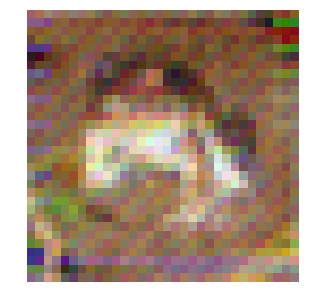

In [5]:
# Data augmentation

import random
from scipy.ndimage import rotate
from matplotlib import pyplot as plt

def shapeTo(arr, ToImg):
    if(ToImg):
        arrEdit = arr.reshape((32,32,3))
    else:
        arrEdit = arr.reshape((32*32*3,1))
    return arrEdit
    
def addBrightnessToHue(imgToEdit):
    randomBright = 0.1#*(np.random.randint(2)*np.random.uniform()-1)
    randomRGB = 2#np.random.randint(3)
    imgToEdit[:,:,randomRGB] = imgToEdit[:,:,randomRGB]-randomBright
    return imgToEdit

def moveAround(imgToEdit):
    maxTilt = 32
    minTilt = 28
    direct = (np.random.randint(2)*-1)
    tiltAxis = int(minTilt+(maxTilt-minTilt)*np.random.uniform())#  int(maxTilt*np.random.uniform())
    imgToEdit = np.roll(imgToEdit, direct*tiltAxis, axis=np.random.randint(0,2))
    return imgToEdit

def jitterAndNoise(imgToEdit):
    noiseAmount = np.random.randint(0,2) -1
    imgToEdit = rotate(imgToEdit, noiseAmount, reshape=False)
    return imgToEdit

# Draw the edited data
def dispImg(img, label):
    # ‘F’ means to read / write the elements using Fortran-like index order, 
    # with the first index changing fastest, and the last index changing slowest.
    loadImg = np.reshape(img, (32, 32, 3), order='F') 
    rotImg = np.rot90(loadImg, k=3) # change to 3 times?
    plt.rcParams["figure.figsize"] = [5,5]
    plt.imshow(rotImg)
    plt.axis('off')
    plt.title(label)

def plotManyImg(dataset,n,m):
    imgNo = 0
    for i in range(n*m): 
        plt.subplot(n, m, i+1)
        dispImg(dataset['images'][i], dataset['labelText'][i])
    plt.show()

def plotNormalizedSet(normSet,n,m):
    imgNo = 0
    for i in range(n*m): 
        plt.subplot(n, m, i+1)
        dispImg(normSet[i], "")
    plt.show()

def normalize(weightMatrix):
    maxVal = np.max(weightMatrix)
    minVal = np.min(weightMatrix)
    return (weightMatrix - minVal) / (maxVal - minVal) 

def augmentBatch(batch):
    batchEdit = np.transpose(batch)
    batchEdit = np.array(batchEdit, copy=True)
    for i in range(len(batchEdit)):
        batchEdit[i] = augmentSingleImage(batchEdit[i])[0]
    return np.transpose(batchEdit)


def augmentSingleImage(imgAsArray):
    imgAsArray = np.array(training['images'][0], copy=True) 
    np.random.seed(int(np.random.uniform() * 500))
    imgToEdit = shapeTo(imgAsArray,True)
    
    imgToEdit = addBrightnessToHue(imgToEdit)
    imgToEdit = jitterAndNoise(imgToEdit)
    imgToEdit = moveAround(imgToEdit)
    return shapeTo(imgToEdit,False)

normTrain = normalize(np.transpose(training['images']))
normValid = normalize(np.transpose(validate['images']))
normTest = normalize(np.transpose(testing['images']))
    
# Plot the batch normalized images
plotNormalizedSet(np.transpose(normTrain)[0:1],1,1)
plotNormalizedSet(np.transpose(normValid)[0:1],1,1)
plotNormalizedSet(np.transpose(normTest)[0:1],1,1)

if(True):
    # Draws the original image and then a randomly changed one
    plotNormalizedSet(np.transpose(normTrain)[0:1],1,1)
    imgAsArray = np.array(training['images'][0], copy=True) 
    transl = augmentSingleImage(imgAsArray)
    plotNormalizedSet(np.transpose(normalize(transl)),1,1)

    # Translate batch
    #batch_inputData = np.transpose(training['images'][0:500])
    #batch_inputData = augmentBatch(batch_inputData)


In [6]:
# Helping functions

# Softmax function
def softmaxForward(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def reluForward(x):
    return x * (x > 0)

def LReluForward(x):
    alpha=0.01
    lowerThresh = x*alpha
    return np.where(x > lowerThresh, x, lowerThresh)


def batchForward(x, computingCost, avgMean, avgVar, flag):
    
    # You should use these moving averages
    #when you compute the cost and accuracy on the training and validation sets
    #after each epoch.
    if(computingCost):
        mean = avgMean
        var = avgVar
    else:
        mean = np.mean(x,axis=1, keepdims=True)
        var =  np.var(x,axis=1, keepdims=True)
        alpha = 0.99
        # used to set the first inital avgMean
        if(flag == False):
            avgMean  = mean
            avgVar = var
            flag = True
        
        avgMean = (1 - alpha) * mean + alpha * avgMean 
        avgVar = (1 - alpha) * var + alpha * avgVar 
    
    return pow(var, -0.5) * (x - mean), mean, var, x, avgMean, avgVar, flag

# Cross entropy
def crossEntropy(X):
    m = len(X)
    logLikelihood = -np.log(X)
    loss = np.sum(logLikelihood) / m
    return loss

# Calculating functions
def evaluateClassifier(inputData, weights, bias, h_weights, h_bias):
    # Calculate the softmax with dot product of weights and input
    calc1 = calculateLayerForward(inputData, inputWeights, inputBias)
    relu1 = reluForward(calc1)
    calc2 = calculateLayerForward(relu1, h_weights, h_bias)
    softmax2 = softmaxForward(calc2)
    return softmax2

# Returns the net outcome 
def calculateLayerForward(inputData,weights, bias):
    # Calculate the softmax with dot product of weights and input
    calculateNetwork = np.dot(weights, inputData) + bias
    return calculateNetwork


def computeCost(probab, realLabel, weights, lambdaVal):
    winValue = np.multiply(realLabel, probab)
    sumValue = winValue.sum(axis=0)
    # Calculate cross-entropy loss
    # Add regularization
    regularization = lambdaVal * np.sum(np.power(weights, 2))
    crossEntropyLoss = crossEntropy(sumValue) + regularization
    return  crossEntropyLoss

def computeAccuracy(probab, realLabel):
    # Get the index of the real class
    # Select the winning(max value) index of each array
    predict = np.argmax(probab, axis=0)
    realLabel = np.argmax(realLabel, axis=0)
    # Count how many were actually correctly classified
    percOfCorrectlyClassified = (np.sum(predict == realLabel)) / len(realLabel)
    # Divide by number of elements to get percentage
    return percOfCorrectlyClassified 


In [7]:
# Functions for calculating the gradients

def calculateGradient(inputData, probab, realLabel, weights, bias, lambdaVal):
    # Set all entries in @L/@b and @L/@W to zero.
    weightsGradient = np.zeros((np.shape(weights)[0],np.shape(weights)[1]))
    biasGradient = np.zeros((np.shape(bias)[0],np.shape(bias)[1]))
    
    gradients = []
    
    N = np.shape(realLabel)[1]
    for i in range(N):
        # Evaluate p - already have it
        pVal = probab[:, i]
        # X
        inputX = inputData[:, i]
        # y
        target = realLabel[:,i]
        # Let
        gradVal = pVal - target
        gradients.append(gradVal)
        # Add gradient of l(x; y;W; b) w.r.t. b
        biasGradient += np.reshape(gradVal, np.shape(biasGradient))
        # Add gradient of l(x; y;W; b) w.r.t. W:
        weightsGradient += np.outer(gradVal, inputX)

    # Add regularization
    regularization = 2 * lambdaVal * weights
    # Add the gradient for the regularization term
    weightsGradient = (weightsGradient / N) + regularization
    biasGradient = biasGradient / N
    
    gradientChange = np.dot(gradients, weights)
    return weightsGradient, biasGradient, gradientChange

                       
def calculateGradientRelu(inputData, probab, realLabel, weights, bias, lambdaVal):


    weightsGradient = np.zeros((np.shape(weights)[0],np.shape(weights)[1]))
    biasGradient = np.zeros((np.shape(bias)[0],np.shape(bias)[1]))
    
    gradients = []
    N = np.shape(probab)[1]
    
    gradVal = np.multiply(realLabel, np.transpose(probab) > 0)
    for i in range(N):
        inputX = inputData[:, i]
        grad = gradVal[i, :]
        
        gradients.append(grad)
        # Add gradient of l(x; y;W; b) w.r.t. b
        
        biasGradient += np.reshape(grad, np.shape(biasGradient))
        # Add gradient of l(x; y;W; b) w.r.t. W:
        weightsGradient += np.outer(grad, inputX)
    
    # Add regularization
    regularization = 2 * lambdaVal * weights
    # Add the gradient for the regularization term
    weightsGradient = (weightsGradient / N) + regularization
    biasGradient = biasGradient / N
    
    # NOTE: 
    # The gradients for two layer network is not needed but should be here if the network was stacked using more layers
    # This sure came in handy here :)
    gradientChange = np.dot(gradients, weights)
    return weightsGradient, biasGradient, gradientChange, gradVal

def calculateGradientBatch(gradVal, mean, var, data):
    N = np.shape(data)[1]
    
    # HMM - there was no function at the last slide of lecture 4.
    # But - I helped myself out and found this niche tutorial on how to implement it 
    # https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
    # I hope this is okay, since I read though this tutorial and managed to implement it in my code.
    gradients = np.transpose(gradVal)
    derivSqr = pow(var, -0.5)
    xModif = data - mean
    
    derivVar = (pow(var, -1.5)) * -1
    derivVar *= np.sum(gradients * xModif, axis=1, keepdims=True)
    dX = derivSqr * np.sum(gradients, axis=1, keepdims=True) * -1

    # Gradient computations
    gradients = (gradients * derivSqr) + (derivVar * xModif / N) + (dX / N)
    return np.transpose(gradients)



def calculateGradientLRelu(inputData, probab, realLabel, weights, bias, lambdaVal):

    weightsGradient = np.zeros((np.shape(weights)[0],np.shape(weights)[1]))
    biasGradient = np.zeros((np.shape(bias)[0],np.shape(bias)[1]))
    
    gradients = []
    N = np.shape(probab)[1]
    
    
    alpha=0.01
    probabHolder = np.ones_like(probab)
    probabHolder[probab < 0] = alpha
    #return dx*dl
    
    gradVal = np.multiply(realLabel, np.transpose(probabHolder))
    
    for i in range(N):
        inputX = inputData[:, i]
        grad = gradVal[i, :]
        
        gradients.append(grad)
        # Add gradient of l(x; y;W; b) w.r.t. b
        
        biasGradient += np.reshape(grad, np.shape(biasGradient))
        # Add gradient of l(x; y;W; b) w.r.t. W:
        weightsGradient += np.outer(grad, inputX)
    
    # Add regularization
    regularization = 2 * lambdaVal * weights
    # Add the gradient for the regularization term
    weightsGradient = (weightsGradient / N) + regularization
    biasGradient = biasGradient / N
    
    # NOTE: 
    # The gradients for two layer network is not needed but should be here if the network was stacked using more layers
    # This sure came in handy here :)
    gradientChange = np.dot(gradients, weights)
    return weightsGradient, biasGradient, gradientChange, gradVal

   

In [8]:
import math

np.random.seed(5)

n = 10 # First 50 images
inputData = np.transpose(training['images'][0:n])
realLabel = np.transpose(training['label'][0:n])

class LayerObject(object):


    def __init__(self, layerType, nIn, nOut, useBN):
        self.layerType = layerType
        self.nIn = nIn
        self.nOut = nOut
        self.bn = useBN
        
        sigm = math.sqrt(2/nIn)
        variance = pow(sigm,2) 
        
        self.weights = np.random.normal(0.0, variance, (nOut, nIn))
        self.bias = np.random.normal(0.0, variance, (nOut, 1))
       
        self.weightsGradient = np.zeros((nOut, nIn))
        self.biasGradient = np.zeros((nOut, 1))
        
        self.weightMomentum = np.zeros((np.shape(self.weights)))
        self.biasMomentum = np.zeros((np.shape(self.bias)))

        # Keep track of variables in batch normalization
        # This should be it's own type of layer..
        self.bn_mean = 0;
        self.bn_var = 0;
        self.bn_data = np.zeros((nIn, 1))
        self.avgFlag = False
        self.bn_avgMean = 0;
        self.bn_avgVar = 0;
        
    def forwardCalc(self,inputData, computingCost):
        calcLayer = calculateLayerForward(inputData, self.weights , self.bias )
        if(self.layerType=="RELU"):
            if(self.bn):

                calcLayer, currMean, currVar, currData, currAvgMean, currAvgVar, flag = batchForward(calcLayer, computingCost, self.bn_avgMean, self.bn_avgVar, self.avgFlag)
                self.bn_mean = currMean;
                self.bn_var = currVar
                self.bn_data = currData
                self.bn_avgMean = currAvgMean;
                self.bn_avgVar = currAvgVar;
                self.avgFlag = flag;
            activation = reluForward(calcLayer)
        if(self.layerType=="LRELU"):
            if(self.bn):

                calcLayer, currMean, currVar, currData, currAvgMean, currAvgVar, flag = batchForward(calcLayer, computingCost, self.bn_avgMean, self.bn_avgVar, self.avgFlag)
                self.bn_mean = currMean;
                self.bn_var = currVar
                self.bn_data = currData
                self.bn_avgMean = currAvgMean;
                self.bn_avgVar = currAvgVar;
                self.avgFlag = flag;
            activation = LReluForward(calcLayer)
        elif(self.layerType=="SOFTMAX"):
            activation = softmaxForward(calcLayer)
            
        return activation
    
    def gradient(self,inp, out, target, lamdbaVal):
        
        if(self.layerType=="RELU"):
            self.weightsGradient, self.biasGradient, gradTarget, gradVal = calculateGradientRelu(inp, out, target, self.weights, self.bias, lamdbaVal)
            if(self.bn):
                bnGrads = calculateGradientBatch(gradVal, self.bn_mean, self.bn_var, self.bn_data)
                gradTarget = np.dot(bnGrads, self.weights)
        elif(self.layerType=="LRELU"):
            self.weightsGradient, self.biasGradient, gradTarget, gradVal = calculateGradientLRelu(inp, out, target, self.weights, self.bias, lamdbaVal)
            if(self.bn):
                bnGrads = calculateGradientBatch(gradVal, self.bn_mean, self.bn_var, self.bn_data)
                gradTarget = np.dot(bnGrads, self.weights)
                
        elif(self.layerType=="SOFTMAX"):
            self.weightsGradient, self.biasGradient, gradTarget = calculateGradient(inp, out, target, self.weights, self.bias, lamdbaVal)

        return gradTarget;
    
    def update(self, eta, mom ):
        self.weightMomentum = mom * self.weightMomentum + eta * self.weightsGradient
        self.biasMomentum = mom * self.biasMomentum + eta * self.biasGradient
        
        self.weights -= self.weightMomentum
        self.bias -= self.biasMomentum
    
class Network(object):
    def __init__(self, eta = 0.01, epoch=5, batch=500, lambdaVal = 0.000000, momentum= 0.9, decay=0.95):
        
        self.layers = []
        self.nLayers = 0
        self.activations = []
        self.gradients = []
        
        # Values for training
        self.eta = eta
        self.epoch = epoch
        self.batch = batch
        self.decayRate = decay
        self.lambdaVal = lambdaVal
        self.momentum = momentum
        self.startingEta = eta
        
        self.computingCost = False
    
    def networkInfo(self):
        return "Network Eta:" + str(self.startingEta) + " epoch: " + str(self.epoch) + " batch: " + str(self.batch)+ " lambdaVal: " + str(self.lambdaVal)+ " momentum: " + str(self.momentum) + " decay:" + str(self.decayRate)
    
    def layerInfo(self):
        infoString = "Layers "
        for i in range(self.nLayers):
            infoString+= "(" + str(self.layers[i].nIn) + "," + str(self.layers[i].nOut) + ")"
            if( i != self.nLayers -1): 
                infoString += " -> "
            
        return infoString
    
    def putLayer(self, layer):
        self.layers.append(layer)
        self.nLayers += 1
        self.activations.append([])
        self.gradients.append([])

    
    def updateWeights(self):
        for i in range(self.nLayers):
            #print(i)
            self.layers[i].update(self.eta, self.momentum)
    
    def feedForwardEvaluate(self, myInputData, corrLabel):
        
        for i in range(self.nLayers):
            if(i == 0):
                act = self.layers[i].forwardCalc(myInputData, self.computingCost)
                self.activations[i] = act
            else:
                act = self.layers[i].forwardCalc(self.activations[i-1], self.computingCost)
                self.activations[i] = act

            if(i == self.nLayers-1):
                cost = computeCost(self.activations[i], corrLabel,  self.layers[i].weights, self.lambdaVal)
                acc = computeAccuracy(self.activations[i], corrLabel)
                return cost, acc
                

    def calcGradients(self,myInputData, myRealLabel):
        
        for i in reversed(range(self.nLayers)):
            if(i != 0):
                if(i == self.nLayers-1):
                    target = myRealLabel;
                else:
                    target = self.gradients[i+1]
                
                gradChange = self.layers[i].gradient(self.activations[i-1],self.activations[i],target, self.lambdaVal)
                self.gradients[i] = gradChange
            else:
                self.layers[i].gradient(myInputData,self.activations[i],self.gradients[i+1], self.lambdaVal)


    
myNetwork = Network();

#myNetwork.putLayer(LayerObject("RELU",3072,50, True))
#myNetwork.putLayer(LayerObject("RELU",50,30, True))
myNetwork.putLayer(LayerObject("LRELU",3072,50, True))
myNetwork.putLayer(LayerObject("LRELU",50,30, True))
myNetwork.putLayer(LayerObject("SOFTMAX",30,10, False))
cost, acc = myNetwork.feedForwardEvaluate(inputData, realLabel)
print("Cost:",cost)
print("Accuracy:",acc)
myNetwork.calcGradients(inputData, realLabel)
myNetwork.updateWeights()

myNetwork.computingCost = True
cost, acc = myNetwork.feedForwardEvaluate(inputData, realLabel)
print("Cost:",cost)
print("Accuracy:",acc)

myNetwork.computingCost = False

cost, acc = myNetwork.feedForwardEvaluate(inputData, realLabel)

print("Cost:",cost)
print("Accuracy:",acc)
myNetwork.calcGradients(inputData, realLabel)
myNetwork.updateWeights()

#self

print(myNetwork.layerInfo())

Cost: 2.29406691918
Accuracy: 0.0
Cost: 1.72103171229
Accuracy: 0.5
Cost: 1.98479945293
Accuracy: 0.4
Layers (3072,50) -> (50,30) -> (30,10)


In [10]:
# Info functions for report

def printInfo(training, validation, test, inputNodes, weights,bias,h_w,h_b, outputNodes, eta):
   
    probab = evaluateClassifier(np.transpose(training['images']),  weights,bias,h_w,h_b)
    finalAccuracy = computeAccuracy(probab, np.transpose(training['label']))
    finalCost = computeCost(probab, np.transpose(training['label']),  h_w, lambdaVal)
    print("Info on Training data: Accuracy: " + str(round(finalAccuracy*100,2)) + "% and Cost: " + str(round(finalCost,2) ))

    probab = evaluateClassifier(np.transpose(validation['images']),  weights,bias,h_w,h_b)
    val_finalCost = computeCost(probab, np.transpose(validation['label']),  h_w, lambdaVal)
    val_finalAccuracy = computeAccuracy(probab, np.transpose(validation['label']))
    print("Info on Validation data: Accuracy: " + str(round(val_finalAccuracy*100,2)) + "% and Cost: " + str(round(val_finalCost,2) ))

    probab = evaluateClassifier(np.transpose(test['images']),  weights,bias,h_w,h_b)
    test_finalCost = computeCost(probab, np.transpose(test['label']),  h_w, lambdaVal)
    test_finalAccuracy = computeAccuracy(probab, np.transpose(test['label']))
    print("Info on Testing data: Accuracy: " + str(round(test_finalAccuracy*100,2)) + "% and Cost: " + str(round(test_finalCost,2) ))

          
def plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation ):
    plt.plot(costTraining, label='Training cost')
    plt.plot(costValidation, label='Validation cost')
    plt.legend()
    
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title('Cost')
    plt.show()
    plt.plot(accuracyTraining, label='Training acc')
    plt.plot(accuracyValidation, label='Validation acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.show()

def normalize(weightMatrix):
    maxVal = np.max(weightMatrix)
    minVal = np.min(weightMatrix)
    return (weightMatrix - minVal) / (maxVal - minVal)

def plotweights(W,label):
    for i, row in enumerate(W):
        imgNormalized = normalize(row) # ValueError: Floating point image RGB values must be in the 0..1 range.
        plt.subplot(5, 2, i+1)
        dispImg(imgNormalized, labels[i])
    plt.show()
    
# Run this cell after training to get the information about the trained network
def infoAboutNetwork():
    print("Info on network with lambda=" +str(lambdaVal) + " epochs=" + str(epoch) + " batch=" + str(batch) + " eta="+str(eta) )
    printInfo(training, validate, testing, inputNodes, inputWeights,inputBias, hiddenWeights, hiddenBias, outputNodes, eta)
    plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )
    plotweights(weights, labels)
    


In [11]:

# Creating the training loop with momentum

def train( trainData, validData, aNetwork, anAugment):
    
    nOfSamples = len(trainData['images'])
    nOfBatch = int(nOfSamples / aNetwork.batch)
    
    inputData = np.transpose(trainData['images'])
    realLabel = np.transpose(trainData['label'])
    
    val_inputData = np.transpose(validData['images'])
    val_realLabel = np.transpose(validData['label'])
     
    accuracyTraining = []
    accuracyValidation = []
    costTraining = []
    costValidation = []
    
    # If we are using augmentation, we can loop endlessly through our data since it is always new
    extraLoop = 1
    if(anAugment):
        extraLoop *= 4
    
    for epoch in range(aNetwork.epoch):
        #print("Epoch: " + str(epoch))
        for h in range(extraLoop):
            for i in range(nOfBatch):
                # Prepare batch
                startOfBatch = i * aNetwork.batch
                endOfBatch = (i+1) * aNetwork.batch
                batch_inputData = np.transpose(trainData['images'][startOfBatch:endOfBatch])
                batch_realLabel = np.transpose(trainData['label'][startOfBatch:endOfBatch])

                if(anAugment):
                    batch_inputData = augmentBatch(batch_inputData)

                # Update weights
                _, _ = aNetwork.feedForwardEvaluate(batch_inputData, batch_realLabel)
                aNetwork.calcGradients(batch_inputData, batch_realLabel)
                aNetwork.updateWeights()
            
        # DECAY RATE   
        aNetwork.eta *= aNetwork.decayRate 
        # Use the avg Mean and var
        aNetwork.computingCost = True;
        cost, acc = aNetwork.feedForwardEvaluate(inputData, realLabel)
        valCost, valAcc = aNetwork.feedForwardEvaluate(val_inputData, val_realLabel)
        aNetwork.computingCost = False;

        # Add to list
        accuracyTraining.append(acc)
        accuracyValidation.append(valAcc)
        
        costTraining.append(cost)
        costValidation.append(valCost)
        
    #print("Done")
    return accuracyTraining, accuracyValidation, costTraining, costValidation

In [14]:
# Test the augmentation
AUGMENT = False

np.random.seed(5)



bestMomenum = 0.855267369989
bestEta = 0.00815934255035
bestLambdaVal = 0.0402050897734
bestDecay = 0.731936477927
#augmentNetwork = Network(eta=bestEta, epoch=5,batch=500, lambdaVal=bestLambdaVal , momentum=0.9, decay=bestDecay);

augmentNetwork = Network(eta=0.010062184458341922, epoch=10,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
augmentNetwork.putLayer(LayerObject("LRELU",3072,50,True))
augmentNetwork.putLayer(LayerObject("LRELU",50,30,True))
augmentNetwork.putLayer(LayerObject("SOFTMAX",30,10,False))

training_5000 = {
        'images': training['images'][0:5000] ,
        'label': training['label'][0:5000], 
        'labelText': training['labelText'][0:5000] 
    }
validate_1000 = {
        'images': validate['images'][0:1000] ,
        'label': validate['label'][0:1000], 
        'labelText': validate['labelText'][0:1000] 
    }


accuracyTraining, accuracyValidation, costTraining, costValidation = train(training, validate, augmentNetwork, AUGMENT)

print(augmentNetwork.networkInfo())
augmentNetwork.computingCost = True
cost, acc = augmentNetwork.feedForwardEvaluate(np.transpose(training['images']), np.transpose(training['label']))
print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
cost, acc = augmentNetwork.feedForwardEvaluate(np.transpose(validate['images']), np.transpose(validate['label']))
print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
cost, acc = augmentNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
augmentNetwork.computingCost = False
plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )



Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Network Eta:0.010062184458341922 epoch: 10 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9 decay:0.95
Info on Training data: Accuracy: 50.13% and Cost: 1.48
Info on Validation data: Accuracy: 46.9% and Cost: 1.58
Info on Testing data: Accuracy: 46.82% and Cost: 1.61


NameError: name 'plotTraining' is not defined

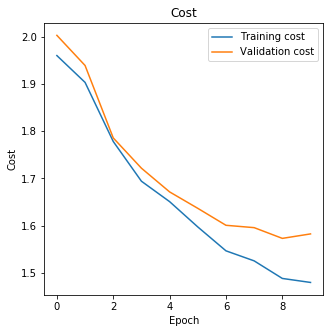

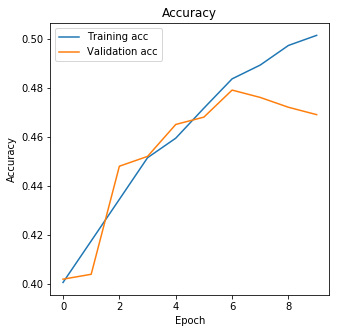

In [16]:
plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )

Starting training on network Layers (3072,50) -> (50,30) -> (30,20) -> (20,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
Network Eta:0.010062184458341922 epoch: 5 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 37.08% and Cost: 1.98
Info on Validation data: Accuracy: 33.4% and Cost: 2.28
Info on Testing data: Accuracy: 30.8% and Cost: 2.23


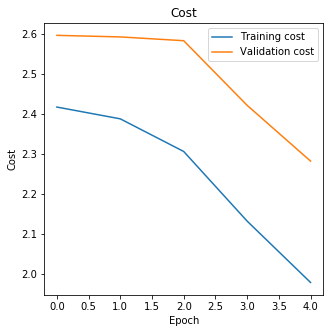

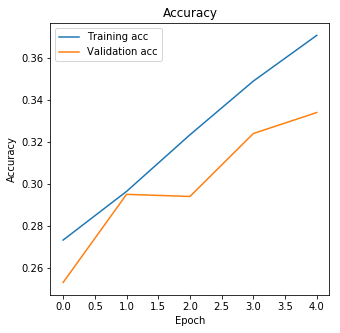

Starting training on network Layers (3072,100) -> (100,50) -> (50,30) -> (30,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
Network Eta:0.010062184458341922 epoch: 5 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 40.42% and Cost: 1.73
Info on Validation data: Accuracy: 36.0% and Cost: 2.1
Info on Testing data: Accuracy: 34.8% and Cost: 1.99


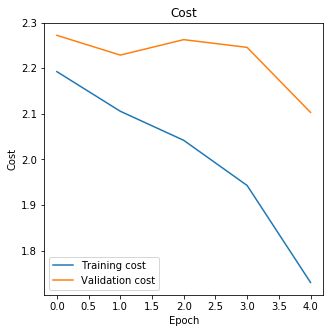

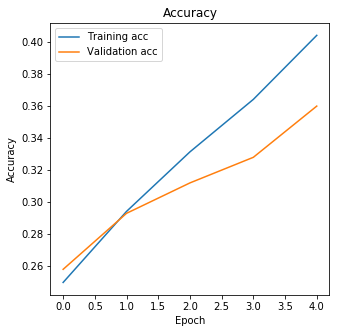

Starting training on network Layers (3072,200) -> (200,100) -> (100,50) -> (50,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
Network Eta:0.010062184458341922 epoch: 5 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 39.72% and Cost: 1.89
Info on Validation data: Accuracy: 35.8% and Cost: 2.3
Info on Testing data: Accuracy: 33.81% and Cost: 2.23


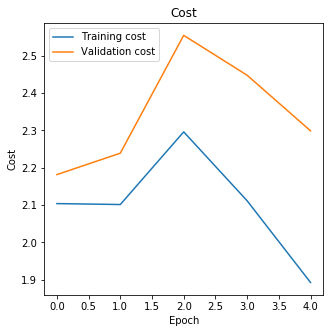

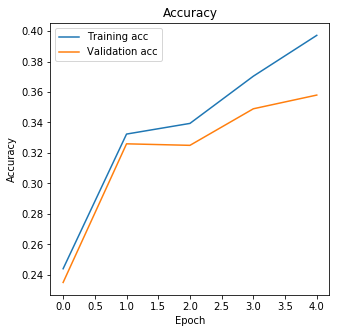

Starting training on network Layers (3072,50) -> (50,40) -> (40,30) -> (30,20) -> (20,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
Network Eta:0.010062184458341922 epoch: 5 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 33.7% and Cost: 2.08
Info on Validation data: Accuracy: 29.6% and Cost: 2.34
Info on Testing data: Accuracy: 28.62% and Cost: 2.3


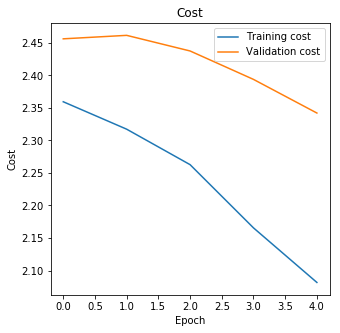

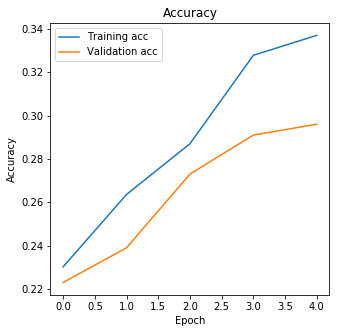

Starting training on network Layers (3072,100) -> (100,50) -> (50,30) -> (30,20) -> (20,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
Network Eta:0.010062184458341922 epoch: 5 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 36.24% and Cost: 1.98
Info on Validation data: Accuracy: 34.0% and Cost: 2.26
Info on Testing data: Accuracy: 29.85% and Cost: 2.28


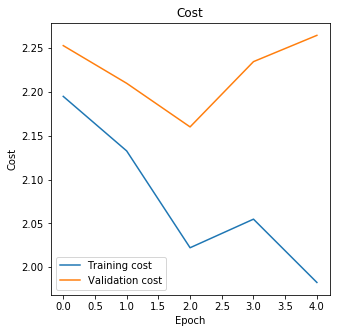

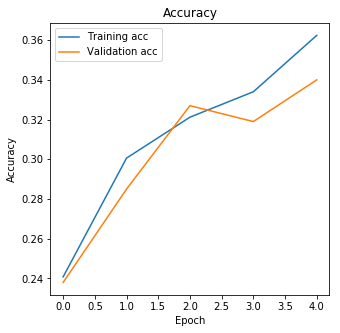

Starting training on network Layers (3072,400) -> (400,200) -> (200,50) -> (50,30) -> (30,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
Network Eta:0.010062184458341922 epoch: 5 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 44.88% and Cost: 1.53
Info on Validation data: Accuracy: 34.4% and Cost: 1.92
Info on Testing data: Accuracy: 34.42% and Cost: 1.87


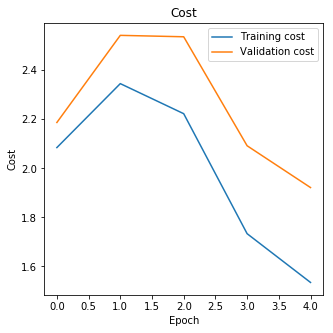

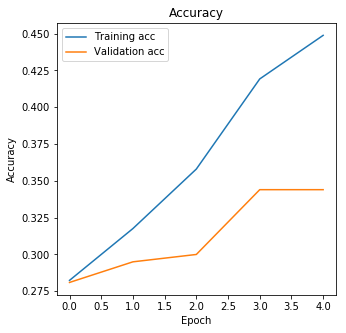

Starting training on network Layers (3072,50) -> (50,40) -> (40,30) -> (30,20) -> (20,15) -> (15,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
Network Eta:0.010062184458341922 epoch: 5 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 31.02% and Cost: 1.99
Info on Validation data: Accuracy: 28.3% and Cost: 2.12
Info on Testing data: Accuracy: 26.46% and Cost: 2.15


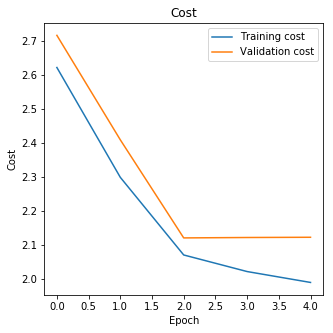

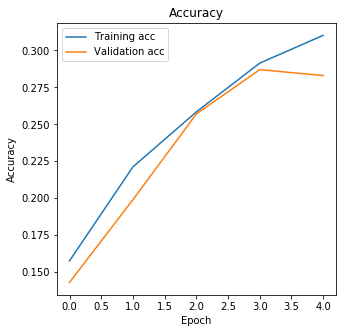

Starting training on network Layers (3072,200) -> (200,100) -> (100,50) -> (50,30) -> (30,20) -> (20,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
Network Eta:0.010062184458341922 epoch: 5 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 38.76% and Cost: 1.84
Info on Validation data: Accuracy: 32.4% and Cost: 2.15
Info on Testing data: Accuracy: 32.02% and Cost: 2.1


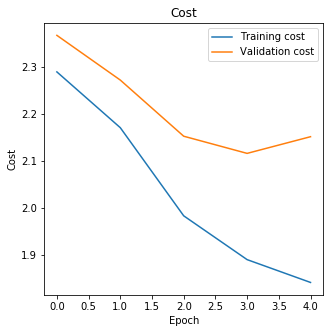

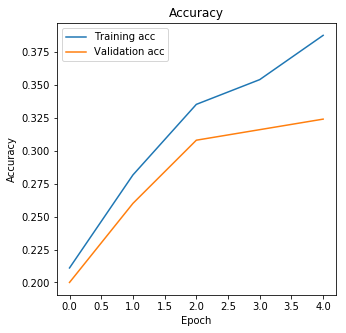

Starting training on network Layers (3072,500) -> (500,200) -> (200,100) -> (100,50) -> (50,30) -> (30,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Done
Network Eta:0.010062184458341922 epoch: 5 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 46.88% and Cost: 1.53
Info on Validation data: Accuracy: 36.1% and Cost: 1.96
Info on Testing data: Accuracy: 35.12% and Cost: 1.9


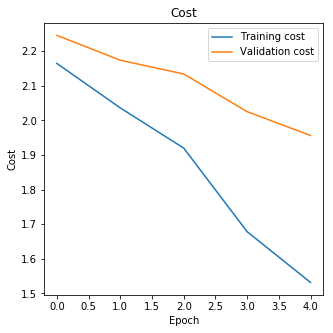

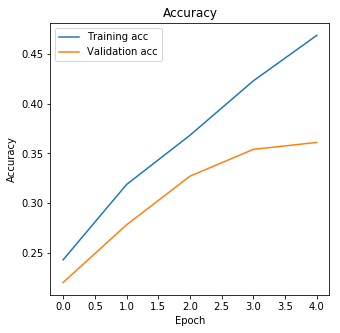

In [315]:
# Test different types of architecture

np.random.seed(5)

training_5000 = {
        'images': training['images'][0:5000] ,
        'label': training['label'][0:5000], 
        'labelText': training['labelText'][0:5000] 
    }
validate_1000 = {
        'images': validate['images'][0:1000] ,
        'label': validate['label'][0:1000], 
        'labelText': validate['labelText'][0:1000] 
    }

networksToTest = []

# 3 types of 4 layers

network1 = Network(eta=0.010062184458341922, epoch=5,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network1.putLayer(LayerObject("RELU",3072,50,True))
network1.putLayer(LayerObject("RELU",50,30,True))
network1.putLayer(LayerObject("RELU",30,20,True))
network1.putLayer(LayerObject("SOFTMAX",20,10,False))
networksToTest.append(network1)

network2 = Network(eta=0.010062184458341922, epoch=5,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network2.putLayer(LayerObject("RELU",3072,100,True))
network2.putLayer(LayerObject("RELU",100,50,True))
network2.putLayer(LayerObject("RELU",50,30,True))
network2.putLayer(LayerObject("SOFTMAX",30,10,False))
networksToTest.append(network2)

network3 = Network(eta=0.010062184458341922, epoch=5,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network3.putLayer(LayerObject("RELU",3072,200,True))
network3.putLayer(LayerObject("RELU",200,100,True))
network3.putLayer(LayerObject("RELU",100,50,True))
network3.putLayer(LayerObject("SOFTMAX",50,10,False))
networksToTest.append(network3)

# 3 types of 5 layers
network4 = Network(eta=0.010062184458341922, epoch=5,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network4.putLayer(LayerObject("RELU",3072,50,True))
network4.putLayer(LayerObject("RELU",50,40,True))
network4.putLayer(LayerObject("RELU",40,30,True))
network4.putLayer(LayerObject("RELU",30,20,True))
network4.putLayer(LayerObject("SOFTMAX",20,10,False))
networksToTest.append(network4)

network5 = Network(eta=0.010062184458341922, epoch=5,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network5.putLayer(LayerObject("RELU",3072,100,True))
network5.putLayer(LayerObject("RELU",100,50,True))
network5.putLayer(LayerObject("RELU",50,30,True))
network5.putLayer(LayerObject("RELU",30,20,True))
network5.putLayer(LayerObject("SOFTMAX",20,10,False))
networksToTest.append(network5)

network6 = Network(eta=0.010062184458341922, epoch=5,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network6.putLayer(LayerObject("RELU",3072,400,True))
network6.putLayer(LayerObject("RELU",400,200,True))
network6.putLayer(LayerObject("RELU",200,50,True))
network6.putLayer(LayerObject("RELU",50,30,True))
network6.putLayer(LayerObject("SOFTMAX",30,10,False))
networksToTest.append(network6)


# 3 types of 6 layers
network7 = Network(eta=0.010062184458341922, epoch=5,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network7.putLayer(LayerObject("RELU",3072,50,True))
network7.putLayer(LayerObject("RELU",50,40,True))
network7.putLayer(LayerObject("RELU",40,30,True))
network7.putLayer(LayerObject("RELU",30,20,True))
network7.putLayer(LayerObject("RELU",20,15,True))
network7.putLayer(LayerObject("SOFTMAX",15,10,False))
networksToTest.append(network7)

network8 = Network(eta=0.010062184458341922, epoch=5,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network8.putLayer(LayerObject("RELU",3072,200,True))
network8.putLayer(LayerObject("RELU",200,100,True))
network8.putLayer(LayerObject("RELU",100,50,True))
network8.putLayer(LayerObject("RELU",50,30,True))
network8.putLayer(LayerObject("RELU",30,20,True))
network8.putLayer(LayerObject("SOFTMAX",20,10,False))
networksToTest.append(network8)

network9 = Network(eta=0.010062184458341922, epoch=5,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network9.putLayer(LayerObject("RELU",3072,500,True))
network9.putLayer(LayerObject("RELU",500,200,True))
network9.putLayer(LayerObject("RELU",200,100,True))
network9.putLayer(LayerObject("RELU",100,50,True))
network9.putLayer(LayerObject("RELU",50,30,True))
network9.putLayer(LayerObject("SOFTMAX",30,10,False))
networksToTest.append(network9)


for i in range(len(networksToTest)):

    aNetwork = networksToTest[i]
    print("Starting training on network " + aNetwork.layerInfo())
    accuracyTraining, accuracyValidation, costTraining, costValidation = train(training_5000, validate_1000, aNetwork, False)

    print(aNetwork.networkInfo())
    aNetwork.computingCost = True
    cost, acc = aNetwork.feedForwardEvaluate(np.transpose(training_5000['images']), np.transpose(training_5000['label']))
    print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
    cost, acc = aNetwork.feedForwardEvaluate(np.transpose(validate_1000['images']), np.transpose(validate_1000['label']))
    print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
    cost, acc = aNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
    print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
    aNetwork.computingCost = False
    plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )




Starting training on network Layers (3072,100) -> (100,50) -> (50,30) -> (30,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Done
Network Eta:0.010062184458341922 epoch: 15 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 59.89% and Cost: 1.18
Info on Validation data: Accuracy: 49.2% and Cost: 1.51
Info on Testing data: Accuracy: 50.75% and Cost: 1.55


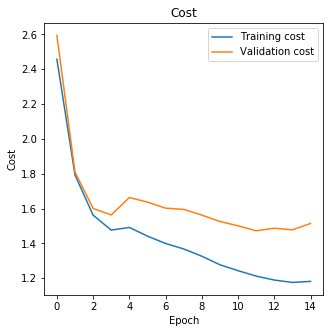

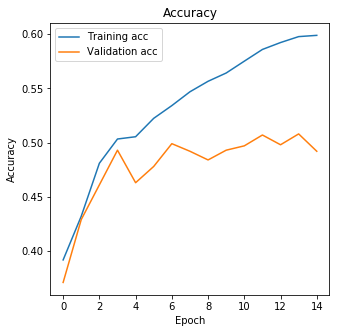

Starting training on network Layers (3072,500) -> (500,200) -> (200,100) -> (100,50) -> (50,30) -> (30,10)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Done
Network Eta:0.010062184458341922 epoch: 15 batch: 500 lambdaVal: 0.0014561487876284364 momentum: 0.9
Info on Training data: Accuracy: 61.47% and Cost: 1.17
Info on Validation data: Accuracy: 46.1% and Cost: 1.75
Info on Testing data: Accuracy: 46.89% and Cost: 1.79


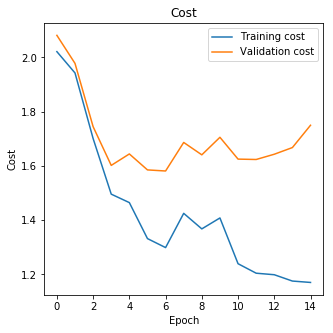

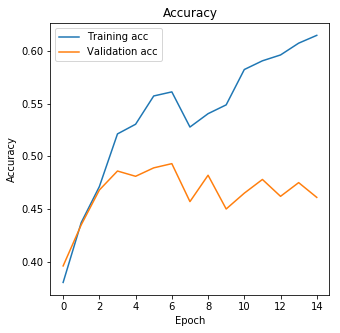

In [335]:
# Test different types of architecture
# Train the top 2 for a longer time on all the data

np.random.seed(5)


networksToTestBetter = []

network2 = Network(eta=0.010062184458341922, epoch=15,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network2.putLayer(LayerObject("RELU",3072,100,True))
network2.putLayer(LayerObject("RELU",100,50,True))
network2.putLayer(LayerObject("RELU",50,30,True))
network2.putLayer(LayerObject("SOFTMAX",30,10,False))
networksToTestBetter.append(network2)

network9 = Network(eta=0.010062184458341922, epoch=15,batch=500, lambdaVal=0.0014561487876284364 , momentum=0.9);
network9.putLayer(LayerObject("RELU",3072,500,True))
network9.putLayer(LayerObject("RELU",500,200,True))
network9.putLayer(LayerObject("RELU",200,100,True))
network9.putLayer(LayerObject("RELU",100,50,True))
network9.putLayer(LayerObject("RELU",50,30,True))
network9.putLayer(LayerObject("SOFTMAX",30,10,False))
networksToTestBetter.append(network9)


for i in range(len(networksToTestBetter)):

    aNetwork = networksToTestBetter[i]
    print("Starting training on network " + aNetwork.layerInfo())
    accuracyTraining, accuracyValidation, costTraining, costValidation = train(training, validate, aNetwork, False)

    print(aNetwork.networkInfo())
    aNetwork.computingCost = True
    cost, acc = aNetwork.feedForwardEvaluate(np.transpose(training['images']), np.transpose(training['label']))
    print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
    cost, acc = aNetwork.feedForwardEvaluate(np.transpose(validate['images']), np.transpose(validate['label']))
    print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
    cost, acc = aNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
    print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
    aNetwork.computingCost = False
    plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )




In [12]:
# Perform the fine and the course search

### WARNING - DO NOT RUN THIS CELL UNLESS YOU HAVE THE TIME FOR IT

NUMBER_OF_DEEP_SEARCHES = 5
NUMBER_OF_SEARCHES = 40

DATAPOINTS = 5000
EPOCHS = 5
BATCH_TESTS = [100, 200, 500, 1000]

MOMENTUM_MAX = 0.9
MOMENTUM_MIN = 0.5
MOMENTUM_HOLDER = [0,0,0,0]

LEARNING_RATE_MAX = 0.01
LEARNING_RATE_MIN = 0.00001
LEARNING_HOLDER = [0,0,0,0]

LAMBDA_MAX = 0.1
LAMBDA_MIN = 0.0001
LAMBDA_HOLDER = [0,0,0,0]

DECAY_MAX = 0.99
DECAY_MIN = 0.5
DECAY_HOLDER = [0,0,0,0]

SEARCH_AUGMENT = False
# Keep values of best

ACCURACY_HOLDER = [0,0,0,0]

# Always use the same validation set
validate_current = {
    'images': validate['images'][0:1000] ,
    'label': validate['label'][0:1000], 
    'labelText': validate['labelText'][0:1000] 
}

for i in range(NUMBER_OF_DEEP_SEARCHES):
    
    training_current = {
        'images': training['images'][0:DATAPOINTS] ,
        'label': training['label'][0:DATAPOINTS], 
        'labelText': training['labelText'][0:DATAPOINTS] 
    }
    
    
    
    for j in range(NUMBER_OF_SEARCHES):
        np.random.seed(5)
        # CREATE SEARCH VALUES HERE
        CURR_BATCH = 500 # BATCH_TESTS[np.random.randint(0,4)]
        CURR_MOMENTUM = MOMENTUM_MIN + (MOMENTUM_MAX - MOMENTUM_MIN)*random.random()
        CURR_DECAY = DECAY_MIN + (DECAY_MAX - DECAY_MIN)*random.random()
        CURR_LAMBDA = LAMBDA_MIN + (LAMBDA_MAX - LAMBDA_MIN)*random.random()
        CURR_ETA = LEARNING_RATE_MIN + (LEARNING_RATE_MAX - LEARNING_RATE_MIN)*random.random()

        
        searchNetwork = Network(eta=CURR_ETA, epoch=EPOCHS,batch=CURR_BATCH, lambdaVal=CURR_LAMBDA , momentum=CURR_MOMENTUM, decay=CURR_DECAY);
        searchNetwork.putLayer(LayerObject("LRELU",3072,50,True))
        searchNetwork.putLayer(LayerObject("LRELU",50,30,True))
        #searchNetwork.putLayer(LayerObject("RELU",3072,50,True))
        #searchNetwork.putLayer(LayerObject("RELU",50,30,True))
        searchNetwork.putLayer(LayerObject("SOFTMAX",30,10,False))
        
        accuracyTraining, accuracyValidation, costTraining, costValidation = train(training_current, validate_current, searchNetwork, SEARCH_AUGMENT)

        searchNetwork.computingCost = True
        print(searchNetwork.networkInfo())
        cost, acc = searchNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
        print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))
        searchNetwork.computingCost = False
        
        # STORE THE ACCURACY
        minAcc = np.argmin(ACCURACY_HOLDER)
        if(acc > ACCURACY_HOLDER[minAcc]):
            ACCURACY_HOLDER[minAcc] = acc

            MOMENTUM_HOLDER[minAcc] = CURR_MOMENTUM
            LEARNING_HOLDER[minAcc] = CURR_ETA
            LAMBDA_HOLDER[minAcc] = CURR_LAMBDA
            DECAY_HOLDER[minAcc] = CURR_DECAY
    
    if(i == NUMBER_OF_DEEP_SEARCHES-1):
        print("Top 10% accuracies Networks found in this search")
        for h in range(len(ACCURACY_HOLDER)):

            print("accuracy:"+str(ACCURACY_HOLDER[h]))
            print("momenum:"+str(MOMENTUM_HOLDER[h])) 
            print("eta:"+str(LEARNING_HOLDER[h]))
            print("lambda:"+str(LAMBDA_HOLDER[h])) 
            print("decay:"+str(DECAY_HOLDER[h]))
    
    # END OF LOOP - PICK BEST PARAMETERS
    MOMENTUM_MAX = np.max(MOMENTUM_HOLDER)
    MOMENTUM_MIN = np.min(MOMENTUM_HOLDER)

    LEARNING_RATE_MAX = np.max(LEARNING_HOLDER)
    LEARNING_RATE_MIN = np.min(LEARNING_HOLDER)

    LAMBDA_MAX = np.max(LAMBDA_HOLDER)
    LAMBDA_MIN = np.min(LAMBDA_HOLDER)

    DECAY_MAX = np.max(DECAY_HOLDER)
    DECAY_MIN = np.min(DECAY_HOLDER)
    
    print("New momentum Max:" + str(MOMENTUM_MAX) + " Min:" + str(MOMENTUM_MIN))
    print("New eta Max:" + str(LEARNING_RATE_MAX) + " Min:" + str(LEARNING_RATE_MIN))
    print("New lambda Max:" + str(LAMBDA_MAX) + " Min:" + str(LAMBDA_MIN))
    print("New decay Max:" + str(DECAY_MAX) + " Min:" + str(DECAY_MIN))

    
    
    # UPGRADE ALL PARAMETERS
    DATAPOINTS += 1000
    EPOCHS+= 2
    # Reset the holder 
    ACCURACY_HOLDER = [0,0,0,0]





Network Eta:0.007708887001636633 epoch: 5 batch: 500 lambdaVal: 0.09632196254894916 momentum: 0.6874372615338432 decay:0.5655357309817324
Info on Testing data: Accuracy: 31.21% and Cost: 2.16
Network Eta:0.009785102944707243 epoch: 5 batch: 500 lambdaVal: 0.09432057928755423 momentum: 0.5896529179626513 decay:0.9197442836609889
Info on Testing data: Accuracy: 33.27% and Cost: 2.1
Network Eta:0.0023988814873310213 epoch: 5 batch: 500 lambdaVal: 0.08003296952388797 momentum: 0.7556882280203194 decay:0.9846834759637708
Info on Testing data: Accuracy: 30.42% and Cost: 2.15
Network Eta:0.004049844989447165 epoch: 5 batch: 500 lambdaVal: 0.026652883531778346 momentum: 0.8534683424418961 decay:0.6200921090974761
Info on Testing data: Accuracy: 31.35% and Cost: 2.04
Network Eta:0.00899688879249208 epoch: 5 batch: 500 lambdaVal: 0.08228840586631066 momentum: 0.6388674580567424 decay:0.899742831147469
Info on Testing data: Accuracy: 33.22% and Cost: 2.09
Network Eta:0.0022079199851871923 epoch: 

Network Eta:0.00662637497961 epoch: 7 batch: 500 lambdaVal: 0.0603505366595 momentum: 0.798871385322 decay:0.856891181573
Info on Testing data: Accuracy: 35.8% and Cost: 2.02
Network Eta:0.00647506746695 epoch: 7 batch: 500 lambdaVal: 0.0632740244588 momentum: 0.658467175699 decay:0.818921408259
Info on Testing data: Accuracy: 33.81% and Cost: 2.08
Network Eta:0.00453382839465 epoch: 7 batch: 500 lambdaVal: 0.0475110695045 momentum: 0.654901996766 decay:0.791800343288
Info on Testing data: Accuracy: 32.35% and Cost: 2.1
Network Eta:0.00473568197448 epoch: 7 batch: 500 lambdaVal: 0.0416750681967 momentum: 0.774343951328 decay:0.876069243316
Info on Testing data: Accuracy: 34.81% and Cost: 2.02
Network Eta:0.00620612117744 epoch: 7 batch: 500 lambdaVal: 0.0335410154198 momentum: 0.843470571335 decay:0.901497264331
Info on Testing data: Accuracy: 36.7% and Cost: 1.93
Network Eta:0.00547811318625 epoch: 7 batch: 500 lambdaVal: 0.0507336583444 momentum: 0.887513949635 decay:0.775325094092
I

Network Eta:0.00907463190561 epoch: 9 batch: 500 lambdaVal: 0.0312437369389 momentum: 0.841399211557 decay:0.838977722633
Info on Testing data: Accuracy: 38.4% and Cost: 1.9
Network Eta:0.00696862992207 epoch: 9 batch: 500 lambdaVal: 0.0233963502661 momentum: 0.832693023424 decay:0.852014052451
Info on Testing data: Accuracy: 38.18% and Cost: 1.89
Network Eta:0.00690004643555 epoch: 9 batch: 500 lambdaVal: 0.0370904334262 momentum: 0.809177156411 decay:0.800108543595
Info on Testing data: Accuracy: 37.16% and Cost: 1.97
Network Eta:0.00641609739878 epoch: 9 batch: 500 lambdaVal: 0.0455442930885 momentum: 0.823827102786 decay:0.804480567754
Info on Testing data: Accuracy: 36.93% and Cost: 1.98
Network Eta:0.00825685647327 epoch: 9 batch: 500 lambdaVal: 0.0421730731289 momentum: 0.822443498081 decay:0.867456533279
Info on Testing data: Accuracy: 38.22% and Cost: 1.94
Network Eta:0.00639633829908 epoch: 9 batch: 500 lambdaVal: 0.0334350257551 momentum: 0.843592115107 decay:0.842891580266


Network Eta:0.00861624548612 epoch: 11 batch: 500 lambdaVal: 0.0233202943058 momentum: 0.854297834141 decay:0.833808492268
Info on Testing data: Accuracy: 39.48% and Cost: 1.87
Network Eta:0.00944098264466 epoch: 11 batch: 500 lambdaVal: 0.0204144545863 momentum: 0.881985854764 decay:0.855845982966
Info on Testing data: Accuracy: 40.32% and Cost: 1.83
Network Eta:0.00820634427551 epoch: 11 batch: 500 lambdaVal: 0.0241831504255 momentum: 0.862151884368 decay:0.875037665293
Info on Testing data: Accuracy: 39.65% and Cost: 1.86
Network Eta:0.00888226269498 epoch: 11 batch: 500 lambdaVal: 0.0206735646465 momentum: 0.854244182613 decay:0.882590771536
Info on Testing data: Accuracy: 39.8% and Cost: 1.83
Network Eta:0.00917660255893 epoch: 11 batch: 500 lambdaVal: 0.0211708151192 momentum: 0.878121901495 decay:0.883431120965
Info on Testing data: Accuracy: 40.27% and Cost: 1.83
Network Eta:0.00913695555651 epoch: 11 batch: 500 lambdaVal: 0.0210767591094 momentum: 0.872335101473 decay:0.830386

Info on Testing data: Accuracy: 39.72% and Cost: 1.87
Network Eta:0.00830607288766 epoch: 13 batch: 500 lambdaVal: 0.0228787374529 momentum: 0.87311502074 decay:0.877237944123
Info on Testing data: Accuracy: 40.74% and Cost: 1.84
Network Eta:0.00906834097976 epoch: 13 batch: 500 lambdaVal: 0.0231651269512 momentum: 0.878096465151 decay:0.858505933723
Info on Testing data: Accuracy: 40.87% and Cost: 1.85
Network Eta:0.00839591394551 epoch: 13 batch: 500 lambdaVal: 0.0227754344211 momentum: 0.874956537855 decay:0.861414342224
Info on Testing data: Accuracy: 40.99% and Cost: 1.86
Network Eta:0.00929644731531 epoch: 13 batch: 500 lambdaVal: 0.0209659930178 momentum: 0.878654640772 decay:0.874172241836
Info on Testing data: Accuracy: 40.63% and Cost: 1.83
Network Eta:0.00931143661053 epoch: 13 batch: 500 lambdaVal: 0.0237542648626 momentum: 0.867586768649 decay:0.881057764003
Info on Testing data: Accuracy: 40.12% and Cost: 1.86
Network Eta:0.00928596106694 epoch: 13 batch: 500 lambdaVal: 0

In [18]:
# Testing my best network here

# parameters for relu
momenum = 0.855267369989
eta = 0.00815934255035
lambdaVal = 0.0402050897734
decay = 0.731936477927

# parameters for leaky relu 
momenum = 0.868630862338
eta = 0.00936187213673
lambdaVal = 0.0218014476467
decay = 0.874448836071
# Test the difference of batch normalization and not using it

np.random.seed(5)

bestNetwork = Network(eta=eta, epoch=30,batch=500, lambdaVal=lambdaVal , momentum=momenum, decay=decay);
bestNetwork.putLayer(LayerObject("LRELU",3072,50,True))
bestNetwork.putLayer(LayerObject("LRELU",50,30,True))
bestNetwork.putLayer(LayerObject("SOFTMAX",30,10,False))

accuracyTraining, accuracyValidation, costTraining, costValidation = train(training, validate, bestNetwork, False)


    
    

Network Eta:0.00936187213673 epoch: 30 batch: 500 lambdaVal: 0.0218014476467 momentum: 0.868630862338 decay:0.874448836071
Info on Training data: Accuracy: 51.12% and Cost: 1.63
Info on Validation data: Accuracy: 45.4% and Cost: 1.74
Info on Testing data: Accuracy: 44.82% and Cost: 1.76


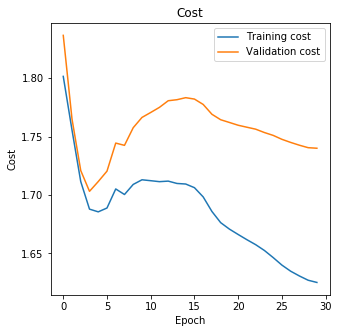

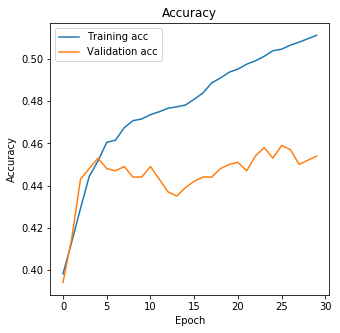

In [19]:
print(bestNetwork.networkInfo())

bestNetwork.computingCost = True
cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(training['images']), np.transpose(training['label']))
print("Info on Training data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(validate['images']), np.transpose(validate['label']))
print("Info on Validation data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

cost, acc = bestNetwork.feedForwardEvaluate(np.transpose(testing['images']), np.transpose(testing['label']))
print("Info on Testing data: Accuracy: " + str(round(acc*100,2)) + "% and Cost: " + str(round(cost,2) ))

bestNetwork.computingCost = False

plotTraining(accuracyTraining, accuracyValidation, costTraining, costValidation )